# Post processing

The purpose of this notebook is to present some of the ways `hydep` can be used to process its own results. At least those generated by the default `h5py` storage system.

<div class="alert alert-info">
    
**Note**
    
This notebook requires the output file generated by [the pincell example](pincell.ipynb)
and `matplotlib`
    
</div>

In [1]:
import numpy
from matplotlib import pyplot
from hydep.hdf import Processor

In [2]:
pincell = Processor("./pincell-results.h5")

## Basic access
The `HdfProcessor` is designed to sit as a convenience layer above the `h5py` API. It can be thought of as a read-only dictionary into the underlying results with the following methods 

In [3]:
pincell.keys()

<KeysViewHDF5 ['compositions', 'cpuTimes', 'fluxes', 'isotopes', 'materials', 'multiplicationFactor', 'time']>

In [4]:
pincell["fluxes"]  # time step, material, group [single group for now]

<HDF5 dataset "fluxes": shape (6, 1, 1), type "<f4">

In [5]:
pincell["time"].keys()

<KeysViewHDF5 ['highFidelity', 'time']>

In [6]:
pincell.get("time/time")

<HDF5 dataset "time": shape (6,), type "<f4">

Our reduced order code simply returned the previous high-fidelity flux, meaning there will be no change from step zero to step 1, even though there are multiple "reduced-order" solutions. We can use the `time/highFidelity` mask to note where our high-fidelity solution was run, even though it may be obvious.

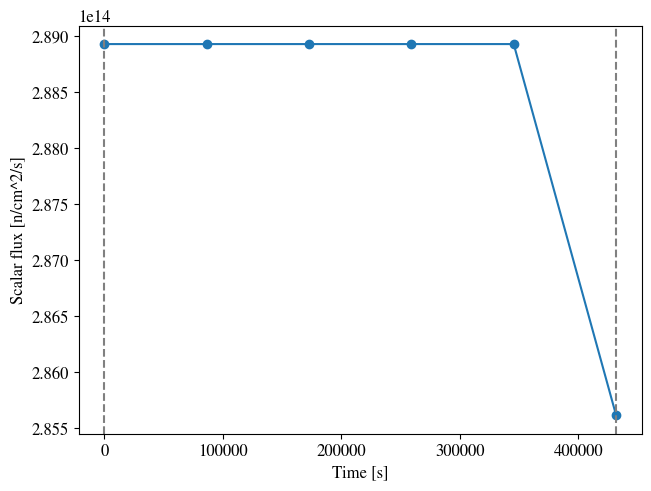

In [7]:
pyplot.plot(
    pincell["time/time"],
    pincell["fluxes"][..., 0, 0], 
    "-o",
)
for t, f in zip(pincell["time/time"], pincell["time/highFidelity"]):
    if f:
        pyplot.axvline(t, color="gray", linestyle="--")
pyplot.xlabel("Time [s]")
pyplot.ylabel("Scalar flux [n/cm^2/s]");

When examining $k$, each time step has the possibility to present a value and the associated standard deviation. Some reduced-order solvers, like the SFV interface, may not provide an estimate on $k$ and thus the array will contain some `nan` elements

In [8]:
pincell["multiplicationFactor"]  # time step, (value, absolute uncertainty pair)

<HDF5 dataset "multiplicationFactor": shape (6, 2), type "<f4">

In [9]:
pincell["multiplicationFactor"][:, 0]

array([1.35933,     nan,     nan,     nan,     nan, 1.33859],
      dtype=float32)

Some indexing tricks can be performed to extract just the values of $k$ computed by the high-fidelity solution

In [10]:
pincell["multiplicationFactor"][pincell["time/highFidelity"][:], :]

array([[1.35933   , 0.01458561],
       [1.33859   , 0.01613001]], dtype=float32)

In [11]:
pincell["compositions"]  # (timestep, material, isotope)

<HDF5 dataset "compositions": shape (6, 1, 223), type "<f4">

In [12]:
pincell["isotopes/zais"]

<HDF5 dataset "zais": shape (223,), type "<i8">

When storing strings in HDF files, they must be converted to character arrays and thus, upon slicing and selecting, must be decoded

In [13]:
pincell["isotopes/names"][-5:]

array([b'Cm242', b'Cm243', b'Cm244', b'Cm245', b'Cm246'], dtype='|S8')

In [14]:
list(b.decode() for b in pincell["isotopes/names"][-5:])

['Cm242', 'Cm243', 'Cm244', 'Cm245', 'Cm246']

Using the `zais` and `names` arrays, one could determine the indices that correspond to specific isotopes of interest. The `zais` vector is sorted, so `numpy.searchsorted` can work quite well

In [15]:
ix = numpy.searchsorted(pincell["isotopes/zais"], 922350)

Text(0, 0.5, '$^{235}$U atom density [atoms/b-cm]')

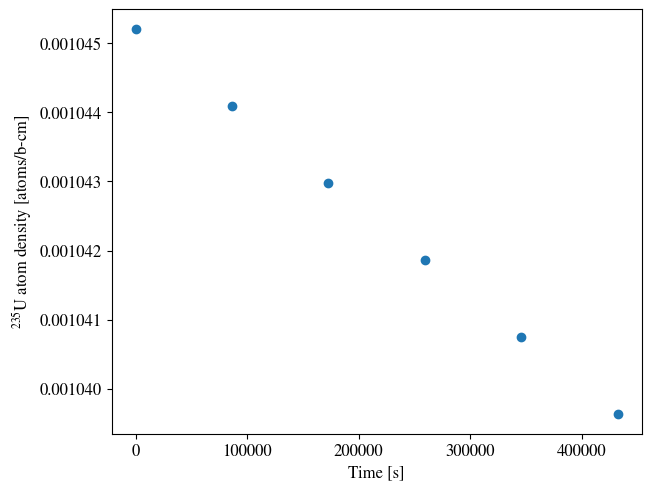

In [16]:
pyplot.plot(pincell["time/time"], pincell["compositions"][..., ix], "o")
pyplot.xlabel("Time [s]")
pyplot.ylabel("$^{235}$U atom density [atoms/b-cm]")

This process can be applied for multiple isotopes as well

<div class="alert alert-warning">
    
**Warning**

If this approach is taken, note that the indices must be sorted in increasing order if indexing directly from the `h5py` dataset. 

</div>

In [17]:
ix = numpy.searchsorted(pincell["isotopes/zais"], [621490, 541350])

In [18]:
try:
    print(pincell["isotopes/names"][ix])
except TypeError as te:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "/home/drew/venv/hydep/lib/python3.8/site-packages/h5py/_hl/selections.py", line 85, in select
    int(a)
TypeError: only size-1 arrays can be converted to Python scalars

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-18-42138b97845a>", line 2, in <module>
    print(pincell["isotopes/names"][ix])
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/home/drew/venv/hydep/lib/python3.8/site-packages/h5py/_hl/dataset.py", line 553, in __getitem__
    selection = sel.select(self.shape, args, dsid=self.id)
  File "/home/drew/venv/hydep/lib/python3.8/site-packages/h5py/_hl/selections.py", line 90, in select
    sel[args]
  File "/home/drew/venv/hydep/lib/python3.8/site-packages/h5py/_hl/selections.py", line 367, in __getitem__
    raise TypeError("Indexing elements must be 

We can instead read in the entire array and then use the index vector to select the isotopes of interest

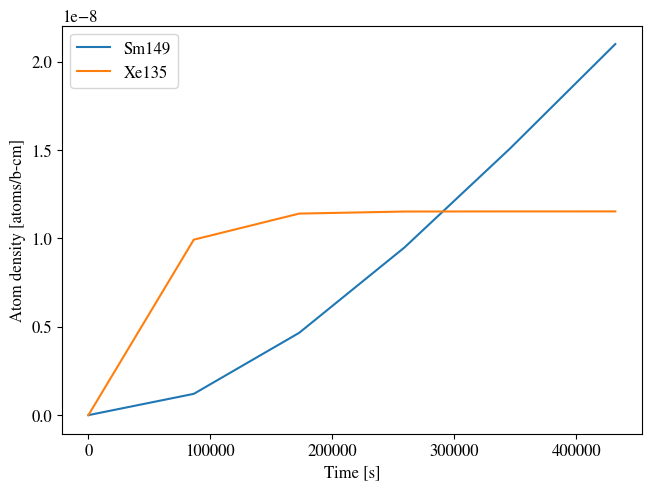

In [19]:
pyplot.plot(pincell["time/time"], pincell["compositions"][:, 0, :][..., ix])
pyplot.legend([n.decode() for n in pincell["isotopes/names"][:][ix]])
pyplot.xlabel("Time [s]")
pyplot.ylabel("Atom density [atoms/b-cm]");

## Convenience methods

The processor has some default methods and attributes that should make processing easier. First, the time in days and string names of isotopes can be directly accessed from the processor

In [20]:
pincell.days

array([0., 1., 2., 3., 4., 5.])

In [21]:
pincell.names[-5:]

('Cm242', 'Cm243', 'Cm244', 'Cm245', 'Cm246')

Many of the datasets can also be accessed through attributes

In [22]:
pincell.fluxes

<HDF5 dataset "fluxes": shape (6, 1, 1), type "<f4">

In [23]:
pincell.compositions

<HDF5 dataset "compositions": shape (6, 1, 223), type "<f4">

In [24]:
pincell.keff

<HDF5 dataset "multiplicationFactor": shape (6, 2), type "<f4">

In [25]:
pincell.hfFlags

<HDF5 dataset "highFidelity": shape (6,), type "|b1">

When extracting $k$, the `getKeff` method can be used to automatically drop any values that originate from the reduced-order code. Additionally, the time returned is in days not in seconds

In [26]:
d, k = pincell.getKeff(hfOnly=True)

<ErrorbarContainer object of 3 artists>

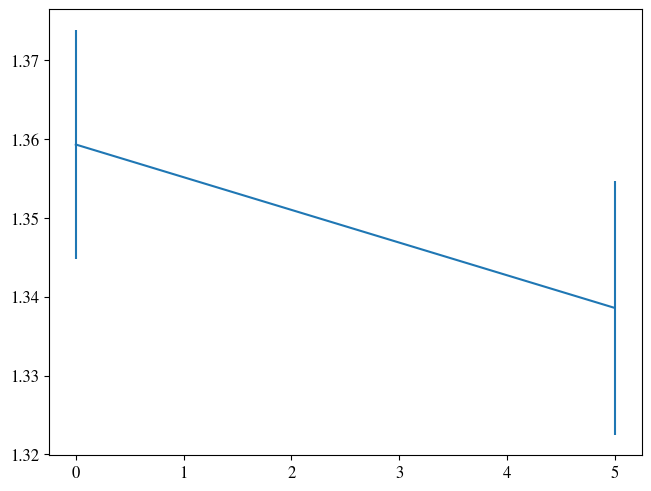

In [27]:
pyplot.errorbar(d, k[:, 0], yerr=k[:, 1])

`getDensities` can be used to extract atom densities for select isotopes, optionally at select time points as well. Since we have a 3D array with the material dimension having a single value, we can squeeze the data to be 2D

In [28]:
adens = pincell.getDensities(names=["Xe135", "Sm149"], days=pincell.days[[0, -1]])
adens.shape

(2, 1, 2)

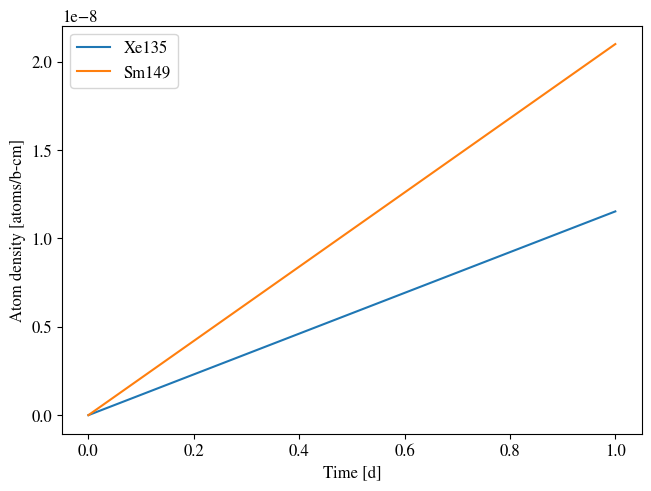

In [29]:
pyplot.plot(pincell.days[[0, 1]], adens.squeeze())
pyplot.xlabel("Time [d]")
pyplot.ylabel("Atom density [atoms/b-cm]")
pyplot.legend(["Xe135", "Sm149"]);